In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

# Helper Functions

In [5]:
import pandas as pd

def reformat_allele(allele: str, resolution: int = 2) -> str:
    """
    Reformats an allele string to a standard format.
    For example, for two-field resolution:
      "A*01:03:XX" -> "A*01:03"
    For one-field resolution:
      "A*01:03" -> "A*01"
    """
    allele = allele.strip()
    if "*" not in allele:
        return allele
    gene, rest = allele.split("*", 1)
    fields = rest.split(":")
    if resolution == 1:
        return f"{gene}*{fields[0]}"
    elif resolution == 2:
        if len(fields) >= 2:
            return f"{gene}*{fields[0]}:{fields[1]}"
        else:
            return f"{gene}*{fields[0]}"
    else:
        return allele

def compare_allele_pair(gs_alleles: list, pre_alleles: list, resolution: int = 2) -> int:
    """
    Compares a pair of gold-standard alleles (list of two strings) 
    with a pair of predicted alleles.
    Returns the maximum number of matches (0, 1, or 2) by checking both 
    the parallel and cross comparisons.
    """
    gs_fmt = [reformat_allele(a, resolution) for a in gs_alleles]
    pre_fmt = [reformat_allele(a, resolution) for a in pre_alleles]
    
    parallel = (gs_fmt[0] == pre_fmt[0]) + (gs_fmt[1] == pre_fmt[1])
    cross = (gs_fmt[0] == pre_fmt[1]) + (gs_fmt[1] == pre_fmt[0])
    return max(parallel, cross)

def compare_allele_pair_filtered(gs_alleles: list, pre_alleles: list, valid_flags: list, resolution: int = 2) -> int:
    """
    Like compare_allele_pair, but only counts a predicted allele if it is valid.
    valid_flags is a list of booleans (one per allele) indicating whether the corresponding
    predicted allele passes the valid-set filter.
    For invalid predictions, that allele is treated as a "no call" (i.e. contributes 0 to the match).
    """
    gs_fmt = [reformat_allele(a, resolution) for a in gs_alleles]
    # For each predicted allele, only reformat it if it is valid; otherwise, set to None.
    pre_fmt = [reformat_allele(a, resolution) if valid else None for a, valid in zip(pre_alleles, valid_flags)]
    
    # For parallel comparison, count a match only if the predicted allele is valid.
    parallel = 0
    if pre_fmt[0] is not None and gs_fmt[0] == pre_fmt[0]:
        parallel += 1
    if pre_fmt[1] is not None and gs_fmt[1] == pre_fmt[1]:
        parallel += 1
    
    # Cross comparison.
    cross = 0
    if pre_fmt[1] is not None and gs_fmt[0] == pre_fmt[1]:
        cross += 1
    if pre_fmt[0] is not None and gs_fmt[1] == pre_fmt[0]:
        cross += 1
    return max(parallel, cross)

def get_dynamic_loci_from_gs(gs_df: pd.DataFrame) -> list:
    """
    Assumes the first column is a sample identifier.
    Every column after that corresponds to a locus.
    If a column name contains a '.1' suffix, it is removed.
    Returns a unique list of locus names.
    """
    loci = set()
    for col in gs_df.columns[1:]:
        # Remove any '.1' suffix
        locus = col.split('.')[0]
        loci.add(locus)
    return list(loci)

def calculate_accuracy(gs_file: str, pre_file: str, resolution: int = 2, filter_option: bool = False):
    """
    Reads the gold standard and prediction CSV files and computes overall accuracy,
    now including a no-calls category.

    Assumptions:
      - The gold-standard CSV (gs_file) has a "Run" column and columns for each locus.
        For each locus, there may be one column (e.g. "DRB1_gs") or two (e.g. "DRB1_gs" and "DRB1.1_gs").
      - The prediction CSV (pre_file) has an "ERR" column that matches the gold standard "Run" identifiers.
        For each locus, predictions are expected in a column named "{locus}_pre"; if a second prediction exists,
        it should be in a column named "{locus}.1_pre". If only one prediction is available for a diploid locus,
        it will be duplicated.
      
    filter_option: if True, only predicted alleles that appear in the gold-standard valid set (built from gs_file)
                   are counted in the accuracy calculation.
    
    Returns:
      A tuple:
        accuracy,            # (total_correct / total_calls)
        total_correct,       # number of matched alleles
        total_calls,         # total diploid calls (2 per locus that has gold-standard data)
        no_calls,            # how many alleles were not called at all
        miscalled_alleles    # list of gold-standard alleles that were miscalled
    """
    gs_df = pd.read_csv(gs_file)
    pre_df = pd.read_csv(pre_file)
    
    # Dynamically determine loci from the gold standard.
    loci = get_dynamic_loci_from_gs(gs_df)
    
    id_col_gs = gs_df.columns[0]
    id_col_pre = pre_df.columns[0]
    merged_df = pd.merge(gs_df, pre_df, left_on=id_col_gs, right_on=id_col_pre, suffixes=("_gs", "_pre"))
    
    total_correct = 0
    total_calls = 0
    no_calls = 0
    miscalled_alleles = []
    
    # Build valid allele sets for filtering if enabled.
    valid_set = {}
    if filter_option:
        valid_set = {locus: set() for locus in loci}
        for _, row in gs_df.iterrows():
            for col in gs_df.columns[1:]:
                locus = col.split('.')[0]
                if locus in loci:
                    gs_val = row[col]
                    if pd.isna(gs_val):
                        continue
                    for allele in str(gs_val).split("/"):
                        valid_set[locus].add(reformat_allele(allele.strip(), resolution))
    
    for _, row in merged_df.iterrows():
        for locus in loci:
            # Retrieve gold-standard alleles from all GS columns for this locus.
            gs_alleles_raw = []
            col1 = f"{locus}_gs"
            col2 = f"{locus}.1_gs"
            if col1 in row and not pd.isna(row[col1]):
                gs_alleles_raw.extend([a.strip() for a in str(row[col1]).split("/")])
            if col2 in row and not pd.isna(row[col2]):
                gs_alleles_raw.extend([a.strip() for a in str(row[col2]).split("/")])
            if not gs_alleles_raw:
                # No gold-standard allele => skip this locus entirely
                continue

            # Each locus is diploid => 2 calls
            total_calls += 2

            # Reformat the gold-standard alleles to a set
            gs_allele_set = set(reformat_allele(a, resolution) for a in gs_alleles_raw)
            # If more than two distinct alleles => ambiguous mode
            use_ambiguous = len(gs_allele_set) > 2

            if not use_ambiguous:
                gs_alleles = list(gs_allele_set)
                if len(gs_alleles) == 1:
                    # If there's only one distinct allele in the set, duplicate it
                    gs_alleles = [gs_alleles[0], gs_alleles[0]]
            
            # Gather predicted alleles
            pre_alleles = []
            pre_col1 = f"{locus}_pre"
            pre_col2 = f"{locus}.1_pre"
            if pre_col1 in row and not pd.isna(row[pre_col1]):
                pre_alleles.extend([a.strip() for a in str(row[pre_col1]).split("/")])
            if pre_col2 in row and not pd.isna(row[pre_col2]):
                pre_alleles.extend([a.strip() for a in str(row[pre_col2]).split("/")])
            
            # ---------------------
            # No-calls logic
            # ---------------------
            if len(pre_alleles) == 0:
                # No predicted alleles => 2 no-calls
                no_calls += 2
                # All miscalled
                miscalled_alleles.extend(gs_allele_set)
                continue
            elif len(pre_alleles) == 1:
                # If only one predicted allele => 1 no-call
                no_calls += 1
                # Duplicate the single allele for pairwise comparison
                pre_alleles = [pre_alleles[0], pre_alleles[0]]
            elif len(pre_alleles) > 2:
                # If more than two, keep only first two
                pre_alleles = pre_alleles[:2]
            
            if len(pre_alleles) != 2:
                # If we still don't have two predicted alleles, skip
                # (though the logic above should produce 2 if there's at least 1)
                miscalled_alleles.extend(gs_allele_set)
                continue
            
            # Compare predicted alleles to gold standard
            if use_ambiguous:
                # In ambiguous mode, each predicted allele is correct if it appears in gs_allele_set
                pred1 = reformat_allele(pre_alleles[0], resolution)
                pred2 = reformat_allele(pre_alleles[1], resolution)
                match_count = (1 if pred1 in gs_allele_set else 0) + (1 if pred2 in gs_allele_set else 0)
            else:
                match_count = compare_allele_pair(gs_alleles, pre_alleles, resolution)
            
            if filter_option:
                # Evaluate valid_flags
                valid_flags = []
                for allele in pre_alleles:
                    allele_fmt = reformat_allele(allele, resolution)
                    valid_flags.append(allele_fmt in valid_set[locus])
                
                valid_call_count = sum(valid_flags)
                
                # Overwrite the "match_count" with the filtered version if not ambiguous
                if not use_ambiguous:
                    match_count = compare_allele_pair_filtered(gs_alleles, pre_alleles, valid_flags, resolution)
                
                # total_calls was already incremented by 2 above
                # We'll only count valid predictions in the denominator if you prefer:
                # But typically we keep the 2 calls for diploid logic.
                
                total_correct += match_count
                if match_count < valid_call_count:
                    miscalled_alleles.extend(gs_allele_set)
            else:
                total_correct += match_count
                # We keep total_calls at 2
                if match_count < 2:
                    miscalled_alleles.extend(gs_allele_set)
    
    accuracy = total_correct / total_calls if total_calls > 0 else 0
    return accuracy, total_correct, total_calls, no_calls, miscalled_alleles


# Accuracy by Dataset

In [6]:
import pandas as pd

# List of tool names that you want to evaluate.
tools = ["arcas", "optitype", "seq2hla", "hlaminer", "phlat", "hlavbseq", "hlahd"]
# Dataset numbers to iterate over.
dataset_nums = range(1, 9)

# List to store results.
results = []

# Loop over each tool and each dataset.
for tool in tools:
    for ds in dataset_nums:
        gs_file = f"../datasets/{ds}_gs.csv"          # Gold standard file for dataset ds.
        pre_file = f"../results/standard/{tool}_d{ds}.csv"  # Prediction file for the tool on dataset ds.
        try:
            # Call the updated accuracy function, which returns (accuracy, total_correct, total_calls, no_calls, miscalled_alleles).
            accuracy, correct, calls, no_calls, miscalled = calculate_accuracy(
                gs_file,
                pre_file,
                resolution=2,
                filter_option=False
            )
            # Append the results to our list
            results.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy,
                "CorrectCalls": correct,
                "TotalCalls": calls,
                "NoCalls": no_calls,
                "NumMiscalled": len(miscalled)
            })
            print(f"Processed {tool} on dataset {ds}: Accuracy = {accuracy:.3f}")
        except Exception as e:
            print(f"Error processing {tool} on dataset {ds}: {e}")

# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)
print("\nSummary of Accuracy Evaluations:")
print(df_results)

# Optionally, save to a CSV file
# df_results.to_csv("accuracy_summary.csv", index=False)


Processed arcas on dataset 1: Accuracy = 0.937
Processed arcas on dataset 2: Accuracy = 0.948
Processed arcas on dataset 3: Accuracy = 0.677
Processed arcas on dataset 4: Accuracy = 0.143
Processed arcas on dataset 5: Accuracy = 1.000
Processed arcas on dataset 6: Accuracy = 1.000
Processed arcas on dataset 7: Accuracy = 0.150
Error processing arcas on dataset 8: [Errno 2] No such file or directory: '../results/standard/arcas_d8.csv'
Processed optitype on dataset 1: Accuracy = 0.982
Processed optitype on dataset 2: Accuracy = 0.000
Processed optitype on dataset 3: Accuracy = 0.940
Processed optitype on dataset 4: Accuracy = 0.000
Processed optitype on dataset 5: Accuracy = 0.625
Processed optitype on dataset 6: Accuracy = 1.000
Processed optitype on dataset 7: Accuracy = 0.263
Error processing optitype on dataset 8: [Errno 2] No such file or directory: '../results/standard/optitype_d8.csv'
Processed seq2hla on dataset 1: Accuracy = 0.920
Processed seq2hla on dataset 2: Accuracy = 0.292

# Bulk Accuracy

In [7]:
import pandas as pd

# List of tool names that you want to evaluate.
tools = ["arcas", "optitype", "seq2hla", "hlaminer", "phlat", "hla_vbseq", "hlahd", "hisat_genotype"]
# Dataset numbers to iterate over.
dataset_nums = range(1, 9)

# Lists to store per-dataset results for each resolution/filter combination.
results_2field = []
results_1field = []
results_2field_filtered = []
results_1field_filtered = []

# Loop over each tool and each dataset.
for tool in tools:
    for ds in dataset_nums:
        gs_file = f"../datasets/{ds}_gs.csv"          # Gold standard file for dataset ds.
        pre_file = f"../results/standard/{tool}_d{ds}.csv"  # Prediction file for the tool on dataset ds.
        try:
            # Call the updated accuracy function, returning:
            # (accuracy, total_correct, total_calls, no_calls, miscalled_alleles).
            accuracy_2field, correct_2field, calls_2field, no_calls_2field, miscalled_2field = calculate_accuracy(
                gs_file, pre_file, resolution=2, filter_option=False
            )
            accuracy_1field, correct_1field, calls_1field, no_calls_1field, miscalled_1field = calculate_accuracy(
                gs_file, pre_file, resolution=1, filter_option=False
            )
            accuracy_2field_filt, correct_2field_filt, calls_2field_filt, no_calls_2field_filt, miscalled_2field_filt = calculate_accuracy(
                gs_file, pre_file, resolution=2, filter_option=True
            )
            accuracy_1field_filt, correct_1field_filt, calls_1field_filt, no_calls_1field_filt, miscalled_1field_filt = calculate_accuracy(
                gs_file, pre_file, resolution=1, filter_option=True
            )

            # Store the results for 2-field (unfiltered)
            results_2field.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy_2field,
                "CorrectCalls": correct_2field,
                "TotalCalls": calls_2field,
                "NoCalls": no_calls_2field,
                "NumMiscalled": len(miscalled_2field)
            })

            # Store the results for 1-field (unfiltered)
            results_1field.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy_1field,
                "CorrectCalls": correct_1field,
                "TotalCalls": calls_1field,
                "NoCalls": no_calls_1field,
                "NumMiscalled": len(miscalled_1field)
            })

            # Store the results for 2-field (filtered)
            results_2field_filtered.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy_2field_filt,
                "CorrectCalls": correct_2field_filt,
                "TotalCalls": calls_2field_filt,
                "NoCalls": no_calls_2field_filt,
                "NumMiscalled": len(miscalled_2field_filt)
            })

            # Store the results for 1-field (filtered)
            results_1field_filtered.append({
                "Tool": tool,
                "Dataset": ds,
                "Accuracy": accuracy_1field_filt,
                "CorrectCalls": correct_1field_filt,
                "TotalCalls": calls_1field_filt,
                "NoCalls": no_calls_1field_filt,
                "NumMiscalled": len(miscalled_1field_filt)
            })

            # Print summary for each run
            print(f"Processed {tool} on dataset {ds} - 2field: {accuracy_2field:.3f}, 1field: {accuracy_1field:.3f}, "
                  f"2field_filt: {accuracy_2field_filt:.3f}, 1field_filt: {accuracy_1field_filt:.3f}")

        except Exception as e:
            print(f"Error processing {tool} on dataset {ds}: {e}")

# Convert per-dataset results to DataFrames.
df_2field = pd.DataFrame(results_2field)
df_1field = pd.DataFrame(results_1field)
df_2field_filt = pd.DataFrame(results_2field_filtered)
df_1field_filt = pd.DataFrame(results_1field_filtered)

print("\nPer-dataset Accuracy Evaluations (2-field, unfiltered):")
print(df_2field.head())
print("\nPer-dataset Accuracy Evaluations (1-field, unfiltered):")
print(df_1field.head())
# ... etc.

# Now, group the results by tool to compute bulk accuracy for each scenario.
# We sum CorrectCalls, TotalCalls, and NoCalls. Then we compute BulkAccuracy = CorrectCalls / TotalCalls.
# Optionally, compute a NoCallRate = NoCalls / TotalCalls.

def compute_bulk_accuracy(df):
    grouped = df.groupby("Tool").agg({
        "CorrectCalls": "sum",
        "TotalCalls": "sum",
        "NoCalls": "sum"
    }).reset_index()
    grouped["BulkAccuracy"] = grouped["CorrectCalls"] / grouped["TotalCalls"]
    grouped["NoCallRate"] = grouped["NoCalls"] / grouped["TotalCalls"]
    # Convert to percentages if you want
    grouped["BulkAccuracy%"] = grouped["BulkAccuracy"] * 100
    grouped["NoCallRate%"] = grouped["NoCallRate"] * 100
    return grouped

bulk_2field = compute_bulk_accuracy(df_2field)
bulk_1field = compute_bulk_accuracy(df_1field)
bulk_2field_filt = compute_bulk_accuracy(df_2field_filt)
bulk_1field_filt = compute_bulk_accuracy(df_1field_filt)

print("\nBulk Accuracy (2-field, unfiltered):")
print(bulk_2field)
print("\nBulk Accuracy (1-field, unfiltered):")
print(bulk_1field)
print("\nBulk Accuracy (2-field, filtered):")
print(bulk_2field_filt)
print("\nBulk Accuracy (1-field, filtered):")
print(bulk_1field_filt)

# Optionally, save results to CSV files:
# df_2field.to_csv("results_2field.csv", index=False)
# bulk_2field.to_csv("bulk_2field.csv", index=False)



Processed arcas on dataset 1 - 2field: 0.937, 1field: 0.991, 2field_filt: 0.937, 1field_filt: 0.991
Processed arcas on dataset 2 - 2field: 0.948, 1field: 0.977, 2field_filt: 0.948, 1field_filt: 0.977
Processed arcas on dataset 3 - 2field: 0.677, 1field: 0.970, 2field_filt: 0.677, 1field_filt: 0.970
Processed arcas on dataset 4 - 2field: 0.143, 1field: 0.143, 2field_filt: 0.143, 1field_filt: 0.143
Processed arcas on dataset 5 - 2field: 1.000, 1field: 1.000, 2field_filt: 1.000, 1field_filt: 1.000
Processed arcas on dataset 6 - 2field: 1.000, 1field: 1.000, 2field_filt: 1.000, 1field_filt: 1.000
Processed arcas on dataset 7 - 2field: 0.150, 1field: 0.295, 2field_filt: 0.150, 1field_filt: 0.295
Error processing arcas on dataset 8: [Errno 2] No such file or directory: '../results/standard/arcas_d8.csv'
Processed optitype on dataset 1 - 2field: 0.982, 1field: 0.997, 2field_filt: 0.982, 1field_filt: 0.997
Processed optitype on dataset 2 - 2field: 0.000, 1field: 0.000, 2field_filt: 0.000, 1fie

In [13]:
bulk_2field

,Tool,CorrectCalls,TotalCalls,NoCalls,BulkAccuracy,NoCallRate,BulkAccuracy%,NoCallRate%
0,arcas,5016,5624,140,0.891892,0.024893,89.189189,2.489331
1,hlahd,5050,5424,271,0.931047,0.049963,93.104720,4.996313
2,hlaminer,437,5584,254,0.078259,0.045487,7.825931,4.548711
3,optitype,3217,3378,68,0.952339,0.020130,95.233866,2.013025
4,phlat,4464,5410,12,0.825139,0.002218,82.513863,0.221811
5,seq2hla,4778,5420,12,0.881550,0.002214,88.154982,0.221402


In [14]:
bulk_1field

,Tool,CorrectCalls,TotalCalls,NoCalls,BulkAccuracy,NoCallRate,BulkAccuracy%,NoCallRate%
0,arcas,5402,5624,140,0.960526,0.024893,96.052632,2.489331
1,hlahd,5340,5424,271,0.984513,0.049963,98.451327,4.996313
2,hlaminer,1343,5584,254,0.240509,0.045487,24.050860,4.548711
3,optitype,3275,3378,68,0.969509,0.020130,96.950858,2.013025
4,phlat,4894,5410,12,0.904621,0.002218,90.462107,0.221811
5,seq2hla,5181,5420,12,0.955904,0.002214,95.590406,0.221402


In [15]:
bulk_1field['type']='pre-filter'
bulk_1field_filt['type']='filtered'
field_1_df=pd.concat([bulk_1field,bulk_1field_filt])

bulk_2field['type']='pre-filter'
bulk_2field_filt['type']='filtered'
field_2_df=pd.concat([bulk_2field,bulk_2field_filt])



In [16]:
field_2_df

,Tool,CorrectCalls,TotalCalls,NoCalls,BulkAccuracy,NoCallRate,BulkAccuracy%,NoCallRate%,type
0,arcas,5016,5624,140,0.891892,0.024893,89.189189,2.489331,pre-filter
1,hlahd,5050,5424,271,0.931047,0.049963,93.104720,4.996313,pre-filter
2,hlaminer,437,5584,254,0.078259,0.045487,7.825931,4.548711,pre-filter
3,optitype,3217,3378,68,0.952339,0.020130,95.233866,2.013025,pre-filter
4,phlat,4464,5410,12,0.825139,0.002218,82.513863,0.221811,pre-filter
5,seq2hla,4778,5420,12,0.881550,0.002214,88.154982,0.221402,pre-filter
0,arcas,5016,5624,140,0.891892,0.024893,89.189189,2.489331,filtered
1,hlahd,5050,5424,271,0.931047,0.049963,93.104720,4.996313,filtered
2,hlaminer,437,5584,254,0.078259,0.045487,7.825931,4.548711,filtered
3,optitype,3217,3378,68,0.952339,0.020130,95.233866,2.013025,filtered


## bulk accuracy by class

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# 1) Helper Functions
# --------------------------
classI_loci = {"A", "B", "C"}
classII_loci = {"DRB1", "DQB1"}

def reformat_allele(allele: str, resolution: int = 2) -> str:
    """
    Reformats an allele string to a standard format.
    For two-field resolution:
      "A*01:03:XX" -> "A*01:03"
    For one-field resolution:
      "A*01:03" -> "A*01"
    """
    allele = allele.strip()
    if "*" not in allele:
        return allele
    gene, rest = allele.split("*", 1)
    fields = rest.split(":")
    if resolution == 1:
        return f"{gene}*{fields[0]}"
    elif resolution == 2:
        if len(fields) >= 2:
            return f"{gene}*{fields[0]}:{fields[1]}"
        else:
            return f"{gene}*{fields[0]}"
    else:
        return allele

def compare_allele_pair(gs_alleles: list, pre_alleles: list, resolution: int = 2) -> int:
    """
    Standard pairwise comparison of a pair of gold-standard alleles (list of two strings)
    with a pair of predicted alleles (list of two strings).
    Returns the maximum number of matches (0, 1, or 2) by checking both parallel and cross.
    """
    gs_fmt = [reformat_allele(a, resolution) for a in gs_alleles]
    pre_fmt = [reformat_allele(a, resolution) for a in pre_alleles]
    parallel = (gs_fmt[0] == pre_fmt[0]) + (gs_fmt[1] == pre_fmt[1])
    cross = (gs_fmt[0] == pre_fmt[1]) + (gs_fmt[1] == pre_fmt[0])
    return max(parallel, cross)

def compare_allele_pair_filtered(gs_alleles: list, pre_alleles: list, valid_flags: list, resolution: int = 2) -> int:
    """
    Like compare_allele_pair, but only counts a predicted allele if it is valid.
    valid_flags is a list of booleans (one per allele) indicating whether the corresponding
    predicted allele passes the valid-set filter.
    For invalid predictions, that allele is treated as a "no call" (i.e. contributes 0 to the match).
    """
    gs_fmt = [reformat_allele(a, resolution) for a in gs_alleles]
    pre_fmt = [reformat_allele(a, resolution) if valid else None for a, valid in zip(pre_alleles, valid_flags)]
    parallel = 0
    if pre_fmt[0] is not None and gs_fmt[0] == pre_fmt[0]:
        parallel += 1
    if pre_fmt[1] is not None and gs_fmt[1] == pre_fmt[1]:
        parallel += 1
    cross = 0
    if pre_fmt[1] is not None and gs_fmt[0] == pre_fmt[1]:
        cross += 1
    if pre_fmt[0] is not None and gs_fmt[1] == pre_fmt[0]:
        cross += 1
    return max(parallel, cross)

def get_dynamic_loci_from_gs(gs_df: pd.DataFrame) -> list:
    """
    Assumes the first column of gs_df is the sample identifier.
    Every column after that corresponds to a locus.
    If a column name contains a ".1" suffix, it is removed.
    Returns a unique list of locus names.
    """
    loci = set()
    for col in gs_df.columns[1:]:
        locus = col.split('.')[0]
        loci.add(locus)
    return list(loci)

def is_no_call(allele_str: str) -> bool:
    """
    Returns True if the allele string represents a no call.
    """
    if not allele_str or pd.isna(allele_str):
        return True
    s = allele_str.strip().lower()
    return (s == "" or s == "." or s == "nan")

# --------------------------
# 2) Main Bulk Accuracy by Class Function
#    (This code will be run twice, one with filter_option=False and one with filter_option=True)
# --------------------------

def run_bulk_accuracy_by_class(filter_option: bool, resolution: int = 2):
    """
    Loops over all tools and datasets, computing bulk accuracy by HLA class
    (Class I and Class II) and tracking no-calls. Returns a DataFrame with aggregated
    results for the given filter_option setting.
    """
    # Define tools and dataset numbers.
    tools = ["arcas", "optitype", "seq2hla", "hlaminer", "phlat", "hlavbseq", "hlahd"]
    dataset_nums = range(1, 9)
    
    # Initialize counts for each tool and HLA class.
    tool_counts = {
        tool: {
            "I": {"correct": 0, "calls": 0, "no_calls": 0},
            "II": {"correct": 0, "calls": 0, "no_calls": 0}
        }
        for tool in tools
    }
    
    # If filtering is enabled, build valid allele sets from the gold standard per locus.
    # We'll build this per dataset inside the loop.
    
    for tool in tools:
        for ds in dataset_nums:
            gs_file = f"../datasets/{ds}_gs.csv"          
            pre_file = f"../results/standard/{tool}_d{ds}.csv"
            try:
                gs_df = pd.read_csv(gs_file)
                pre_df = pd.read_csv(pre_file)
                
                # Get dynamic loci from the GS file.
                loci = get_dynamic_loci_from_gs(gs_df)
                
                # If filtering is enabled, build a valid set from the GS file.
                valid_set = {}
                if filter_option:
                    valid_set = {locus: set() for locus in loci}
                    for _, row in gs_df.iterrows():
                        for col in gs_df.columns[1:]:
                            locus = col.split('.')[0]
                            if locus in loci:
                                gs_val = row[col]
                                if pd.isna(gs_val):
                                    continue
                                for allele in str(gs_val).split("/"):
                                    valid_set[locus].add(reformat_allele(allele.strip(), resolution))
                
                # Merge on sample identifier.
                id_col_gs = gs_df.columns[0]
                id_col_pre = pre_df.columns[0]
                merged_df = pd.merge(gs_df, pre_df, left_on=id_col_gs, right_on=id_col_pre,
                                     suffixes=("_gs", "_pre"))
                
                # Process each sample.
                for _, row in merged_df.iterrows():
                    for locus in loci:
                        # Determine class for the locus.
                        if locus in classI_loci:
                            cls = "I"
                        elif locus in classII_loci:
                            cls = "II"
                        else:
                            continue
                            
                        # Retrieve GS alleles from all GS columns for the locus.
                        gs_alleles_raw = []
                        col1 = f"{locus}_gs"
                        col2 = f"{locus}.1_gs"
                        if col1 in row and not pd.isna(row[col1]):
                            gs_alleles_raw.extend(a.strip() for a in str(row[col1]).split("/"))
                        if col2 in row and not pd.isna(row[col2]):
                            gs_alleles_raw.extend(a.strip() for a in str(row[col2]).split("/"))
                        if not gs_alleles_raw:
                            continue
                        
                        # Each locus contributes 2 diploid calls.
                        tool_counts[tool][cls]["calls"] += 2
                        
                        # Form the gold standard allele set.
                        gs_allele_set = set(reformat_allele(a, resolution) for a in gs_alleles_raw)
                        use_ambiguous = len(gs_allele_set) > 2
                        if not use_ambiguous:
                            gs_list = list(gs_allele_set)
                            if len(gs_list) == 1:
                                gs_list = [gs_list[0], gs_list[0]]
                        
                        # Retrieve predicted alleles.
                        pre_alleles = []
                        pre_col1 = f"{locus}_pre"
                        pre_col2 = f"{locus}.1_pre"
                        if pre_col1 in row and not pd.isna(row[pre_col1]):
                            pre_alleles.extend(a.strip() for a in str(row[pre_col1]).split("/"))
                        if pre_col2 in row and not pd.isna(row[pre_col2]):
                            pre_alleles.extend(a.strip() for a in str(row[pre_col2]).split("/"))
                        
                        # No predicted alleles => record 2 no-calls.
                        if len(pre_alleles) == 0:
                            tool_counts[tool][cls]["no_calls"] += 2
                            continue
                        elif len(pre_alleles) == 1:
                            tool_counts[tool][cls]["no_calls"] += 1
                            pre_alleles = [pre_alleles[0], pre_alleles[0]]
                        elif len(pre_alleles) > 2:
                            pre_alleles = pre_alleles[:2]
                        if len(pre_alleles) != 2:
                            continue
                            
                        # Check for individual predicted no-calls.
                        for i in range(2):
                            if is_no_call(pre_alleles[i]):
                                tool_counts[tool][cls]["no_calls"] += 1
                                pre_alleles[i] = None
                        
                        if all(a is None for a in pre_alleles):
                            continue
                            
                        # Compare predicted alleles to gold standard.
                        if use_ambiguous:
                            # Ambiguous mode: count a predicted allele as correct if it is in the GS set.
                            match_count = 0
                            for a in pre_alleles:
                                if a is not None and reformat_allele(a, resolution) in gs_allele_set:
                                    match_count += 1
                        else:
                            # Standard pairwise comparison.
                            valid_pre = [a if a is not None else "NO_CALL" for a in pre_alleles]
                            match_count = compare_allele_pair(gs_list, valid_pre, resolution)
                        
                        if filter_option:
                            # Adjust match count with filtering.
                            valid_flags = []
                            for a in pre_alleles:
                                allele_fmt = reformat_allele(a, resolution) if a is not None else None
                                valid_flags.append(allele_fmt in valid_set.get(locus, set()) if allele_fmt is not None else False)
                            valid_call_count = sum(valid_flags)
                            if not use_ambiguous:
                                match_count = compare_allele_pair_filtered(gs_list, pre_alleles, valid_flags, resolution)
                            # Note: total calls remain 2 (diploid) per locus.
                        
                        tool_counts[tool][cls]["correct"] += match_count
                        
            except Exception as e:
                print(f"Error processing {tool} on dataset {ds}: {e}")
    
    # Aggregate counts into a list of rows.
    rows = []
    for tool in tools:
        for cls in ["I", "II"]:
            correct = tool_counts[tool][cls]["correct"]
            calls = tool_counts[tool][cls]["calls"]
            no_calls = tool_counts[tool][cls]["no_calls"]
            bulk_accuracy = correct / calls if calls > 0 else 0
            no_call_rate = no_calls / calls if calls > 0 else 0
            rows.append({
                "Tool": tool,
                "Class": cls,
                "CorrectCalls": correct,
                "TotalCalls": calls,
                "NoCalls": no_calls,
                "BulkAccuracy": bulk_accuracy,
                "BulkAccuracy%": bulk_accuracy * 100,
                "NoCallRate": no_call_rate,
                "NoCallRate%": no_call_rate * 100
            })
    
    df_bulk = pd.DataFrame(rows)
    return df_bulk

# --------------------------
# 3) Run Both Modes: Unfiltered and Filtered
# --------------------------
df_bulk_unfiltered = run_bulk_accuracy_by_class(filter_option=False, resolution=2)
df_bulk_filtered   = run_bulk_accuracy_by_class(filter_option=True, resolution=2)
#df_bulk_unfiltered
df_bulk_filtered


Error processing arcas on dataset 8: [Errno 2] No such file or directory: '../results/standard/arcas_d8.csv'
Error processing optitype on dataset 8: [Errno 2] No such file or directory: '../results/standard/optitype_d8.csv'
Error processing seq2hla on dataset 7: [Errno 2] No such file or directory: '../results/standard/seq2hla_d7.csv'
Error processing seq2hla on dataset 8: [Errno 2] No such file or directory: '../results/standard/seq2hla_d8.csv'
Error processing hlaminer on dataset 8: [Errno 2] No such file or directory: '../results/standard/hlaminer_d8.csv'
Error processing phlat on dataset 7: [Errno 2] No such file or directory: '../results/standard/phlat_d7.csv'
Error processing phlat on dataset 8: [Errno 2] No such file or directory: '../results/standard/phlat_d8.csv'
Error processing hlavbseq on dataset 8: [Errno 2] No such file or directory: '../results/standard/hlavbseq_d8.csv'
Error processing hlahd on dataset 7: [Errno 2] No such file or directory: '../results/standard/hlahd_d

,Tool,Class,CorrectCalls,TotalCalls,NoCalls,BulkAccuracy,BulkAccuracy%,NoCallRate,NoCallRate%
0,arcas,I,3008,3384,84,0.888889,88.888889,0.024823,2.482270
1,arcas,II,2008,2240,56,0.896429,89.642857,0.025000,2.500000
2,optitype,I,3217,3378,68,0.952339,95.233866,0.020130,2.013025
3,optitype,II,0,0,0,0.000000,0.000000,0.000000,0.000000
4,seq2hla,I,3032,3264,12,0.928922,92.892157,0.003676,0.367647
5,seq2hla,II,1746,2156,0,0.809833,80.983302,0.000000,0.000000
6,hlaminer,I,206,3360,132,0.061310,6.130952,0.039286,3.928571
7,hlaminer,II,231,2224,122,0.103867,10.386691,0.054856,5.485612
8,phlat,I,2865,3264,12,0.877757,87.775735,0.003676,0.367647
9,phlat,II,1599,2146,0,0.745107,74.510718,0.000000,0.000000


# Figures

In [27]:
from matplotlib import colors as mcolors


# color palette
palette = [mcolors.to_rgba(c) for c in [ "#be6968", '#61ba40',"#6590ca",'coral','orange','gold','skyblue','cornflowerblue', '#e9af61',"#49adad" ] ]


/tmp/ipykernel_2729274/4163528951.py:5: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=field_1_df,x="Tool",y="BulkAccuracy%",ax=ax[0],hue="type",palette=palette)
/tmp/ipykernel_2729274/4163528951.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=field_2_df,x="Tool",y="BulkAccuracy%",ax=ax[1],hue="type",palette=palette)


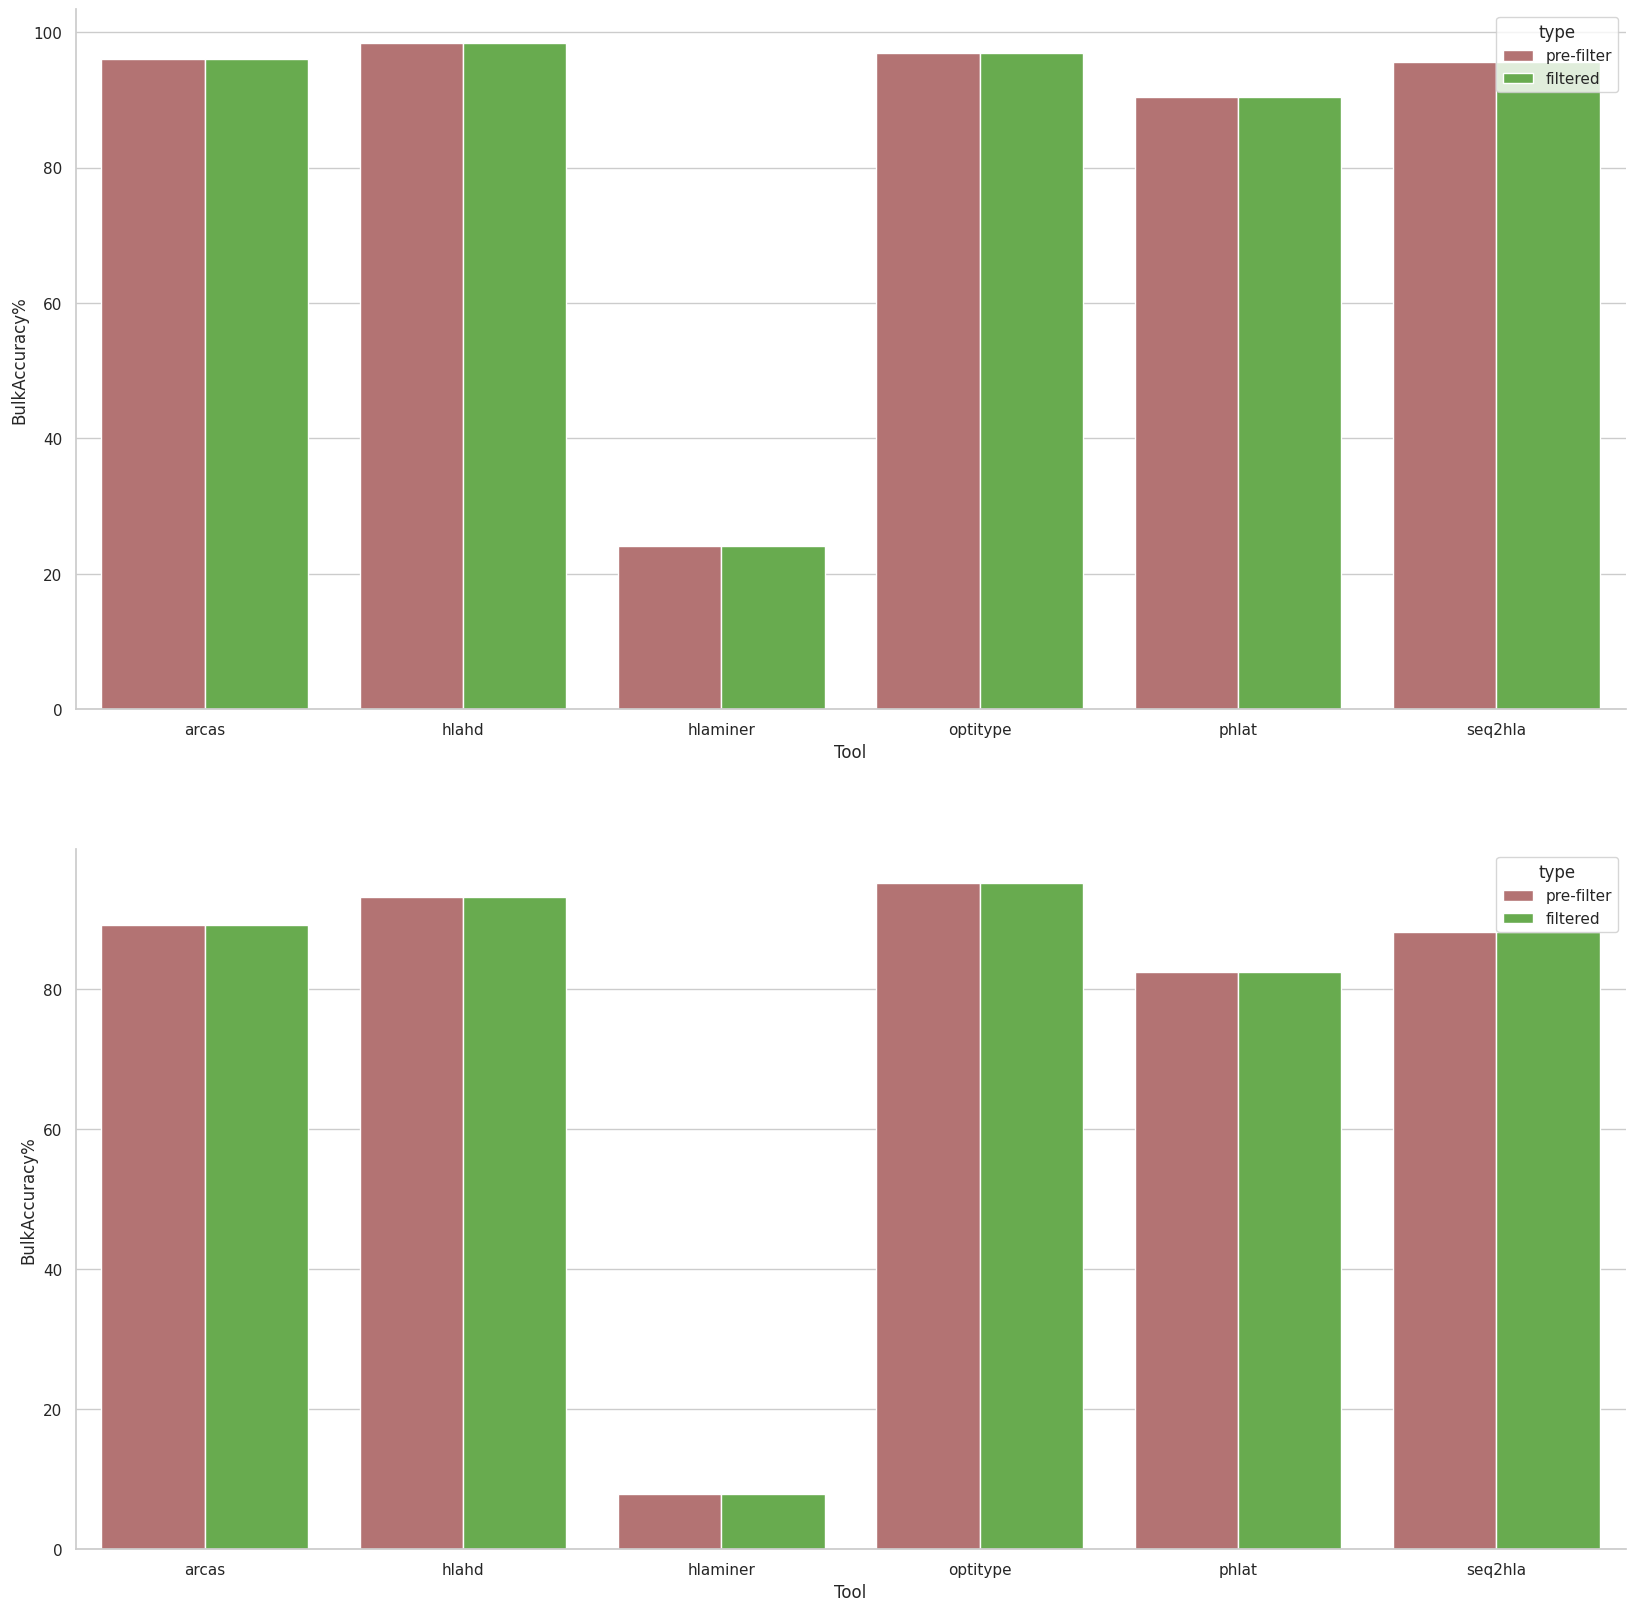

In [28]:
fig = plt.figure(figsize=(20,20))
#add some p value significance to this 
#left plot
ax=fig.subplots(2,1)
sns.barplot(data=field_1_df,x="Tool",y="BulkAccuracy%",ax=ax[0],hue="type",palette=palette)
sns.barplot(data=field_2_df,x="Tool",y="BulkAccuracy%",ax=ax[1],hue="type",palette=palette)
#sns.barplot(data=results_2field,x="Tool",y="BulkAccuracy%",ax=ax[0,0],hue="Tool",palette=palette)
#sns.barplot(data=results_1field,x="Tool",y="BulkAccuracy%",ax=ax[0,1],hue="Tool",palette=palette)
#sns.barplot(data=results_2field_filtered,x="Tool",y="BulkAccuracy%",ax=ax[1,0],hue="Tool",palette=palette)
#sns.barplot(data=results_1field_filtered,x="Tool",y="BulkAccuracy%",ax=ax[1,1],hue="Tool",palette=palette)
sns.despine()

## Figure 4: bulk accuracy by class vertical split

/tmp/ipykernel_2655419/144319365.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


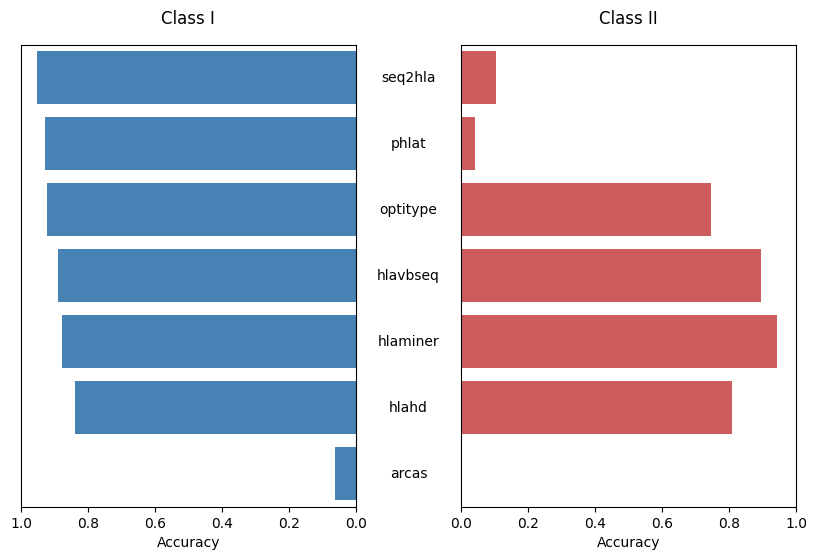

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose df is your DataFrame with columns: ["Tool", "I", "II"] containing
# Class I and Class II accuracies per tool, already sorted.
df=df_bulk_filtered.pivot_table(values="BulkAccuracy", index="Tool", columns="Class").reset_index().rename_axis(None, axis=1)
df=df.sort_values(by=["I", "II"], ascending=[False, False])
fig = plt.figure(figsize=(10, 6))
# Make the center axis quite narrow to minimize white space:
gs = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[1, 0.3, 1], wspace=0.01)

ax_left = fig.add_subplot(gs[0, 0])
ax_center = fig.add_subplot(gs[0, 1])
ax_right = fig.add_subplot(gs[0, 2])

# The y positions for each tool
y_positions = np.arange(len(df))

# -------------------------------
# Left axis: Class I
# -------------------------------
ax_left.barh(y_positions, df["I"], color="steelblue", align="center")
ax_left.set_ylim(-0.5, len(df) - 0.5)
ax_left.set_xlim(0, 1)
ax_left.invert_xaxis()   # so higher accuracy is near the center
ax_left.invert_yaxis()   # so the top row is the first item
ax_left.set_xlabel("Accuracy")
ax_left.set_title("Class I", pad=15)
# Hide y-ticks; we'll place labels in the center axis
ax_left.set_yticks([])
ax_left.set_yticklabels([])

# -------------------------------
# Center axis: narrow space for labels
# -------------------------------
# Match y-limits to the left, invert so the top is y=0
ax_center.set_ylim(ax_left.get_ylim())
ax_center.invert_yaxis()
# Remove all spines and ticks
for spine in ax_center.spines.values():
    spine.set_visible(False)
ax_center.set_xticks([])
ax_center.set_yticks([])

# Manually place each tool label near x=1.0 or 0.5, depending on your preference.
# We'll do x=0.5 so it's truly centered in the narrow subplot.
for i, row in df.iterrows():
    tool_name = row["Tool"]
    ax_center.text(
        0.5,         # x in [0..1] across the center axis
        i,           # y position
        tool_name,
        ha="center", # center horizontally
        va="center", # center vertically
        fontsize=10
    )

# -------------------------------
# Right axis: Class II
# -------------------------------
ax_right.barh(y_positions, df["II"], color="indianred", align="center")
ax_right.set_ylim(ax_left.get_ylim())
ax_right.invert_yaxis()
ax_right.set_xlim(0, 1)
ax_right.set_xlabel("Accuracy")
ax_right.set_title("Class II", pad=15)
# Hide y ticks (labels are in the center axis)
ax_right.set_yticks([])
ax_right.set_yticklabels([])

plt.tight_layout()
plt.show()


/tmp/ipykernel_2655419/1690022124.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


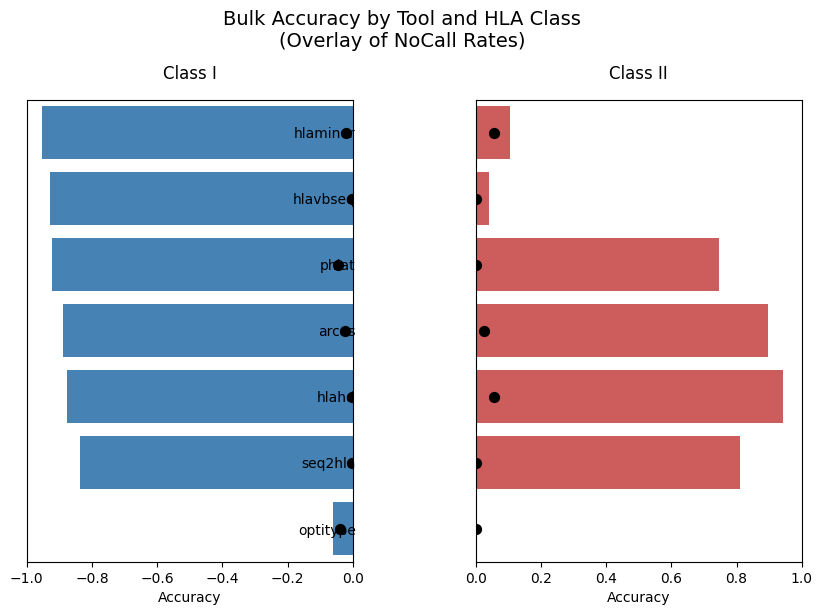

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------------
# 1. Create Pivot Tables from Your Bulk Data
# -------------------------------------------------------------------------
# Assume your source DataFrame (df_bulk_filtered) has columns:
#   "Tool", "Class", "BulkAccuracy", and "NoCallRate"
#
# For example, your original DataFrame might look like:
#    Tool        Class   BulkAccuracy   NoCallRate
#    arcas       I       0.85           0.10
#    arcas       II      0.75           0.05
#    optitype    I       0.99           0.02
#    optitype    II      0.00           0.50
#    ... (multiple rows)
#
# First, pivot to get one row per tool for BulkAccuracy:
df_accuracy = df_bulk_filtered.pivot_table(
    values="BulkAccuracy", index="Tool", columns="Class"
).reset_index().rename_axis(None, axis=1)
# Pivot for NoCallRate as well.
df_nocall = df_bulk_filtered.pivot_table(
    values="NoCallRate", index="Tool", columns="Class"
).reset_index().rename_axis(None, axis=1)

# For convenience, merge these two pivot tables into one DataFrame.
# Suffix _acc for accuracy and _nc for no-call rate.
df_combined = pd.merge(df_accuracy, df_nocall, on="Tool", suffixes=("_acc", "_nc"))
# Ensure that the columns are in the expected order:
# Expected columns: Tool, I_acc, II_acc, I_nc, II_nc.
# (If the column names are not exactly "I" and "II", adjust accordingly.)

# -------------------------------------------------------------------------
# 2. Create the Diverging Bar Plot with Overlay of NoCallRate Markers
# -------------------------------------------------------------------------
# Create a new column for negative Class I values (for bars and markers)
df_combined["I_acc_neg"] = -df_combined["I_acc"]
df_combined["I_nc_neg"]  = -df_combined["I_nc"]

# Sort by one of the metrics if desired (for example, by I_acc descending)
df_combined = df_combined.sort_values(by="I_acc_neg", ascending=True).reset_index(drop=True)

# Get the tools and determine y positions.
tools_list = df_combined["Tool"]
y_positions = np.arange(len(df_combined))

# Create the figure with three subplots: left for Class I, center for labels, right for Class II.
fig = plt.figure(figsize=(10, 6))
# Use a narrow center column so that the labels sit on white background.
gs = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[1, 0.3, 1], wspace=0.05)

ax_left = fig.add_subplot(gs[0, 0])
ax_center = fig.add_subplot(gs[0, 1])
ax_right = fig.add_subplot(gs[0, 2])

# -------------------------------
# Left Axis: Class I
# -------------------------------
# Plot Class I BulkAccuracy as negative bars.
ax_left.barh(y_positions, df_combined["I_acc_neg"], color="steelblue", align="center")
ax_left.set_ylim(-0.5, len(df_combined) - 0.5)
ax_left.set_xlim(-1, 0)  # since values are negative (range from -1 to 0)
ax_left.invert_yaxis()   # so that the first tool is at the top
ax_left.set_xlabel("Accuracy")
ax_left.set_title("Class I", pad=15)
# Remove y-tick labels (to be added in the center axis)
ax_left.set_yticks([])

# Overlay the NoCallRate markers (also negative) on the same plot.
ax_left.scatter(
    df_combined["I_nc_neg"], y_positions,
    color="black", marker="o", s=50, label="NoCall Rate"
)

# -------------------------------
# Center Axis: Tool Labels
# -------------------------------
ax_center.set_xlim(0, 1)  # arbitrary horizontal limits
ax_center.set_ylim(ax_left.get_ylim())
ax_center.invert_yaxis()  # so that ordering matches the left
# Remove all spines and ticks from the center.
for spine in ax_center.spines.values():
    spine.set_visible(False)
ax_center.set_xticks([])
ax_center.set_yticks(y_positions)
ax_center.set_yticklabels(tools_list, fontsize=10)
ax_center.tick_params(left=False, labelleft=True, bottom=False, labelbottom=False)
ax_center.set_xlabel("")
ax_center.set_ylabel("")

# -------------------------------
# Right Axis: Class II
# -------------------------------
ax_right.barh(y_positions, df_combined["II_acc"], color="indianred", align="center")
ax_right.set_ylim(ax_left.get_ylim())
ax_right.invert_yaxis()  # so that ordering matches
ax_right.set_xlim(0, 1)
ax_right.set_xlabel("Accuracy")
ax_right.set_title("Class II", pad=15)
# Remove y-tick labels
ax_right.set_yticks([])
ax_right.set_yticklabels([])

# Overlay the NoCallRate markers on the right axis.
ax_right.scatter(
    df_combined["II_nc"], y_positions,
    color="black", marker="o", s=50, label="NoCall Rate"
)

# -------------------------------
# Final Touches
# -------------------------------
plt.suptitle("Bulk Accuracy by Tool and HLA Class\n(Overlay of NoCall Rates)", y=1.03, fontsize=14)
plt.tight_layout()
plt.show()


/tmp/ipykernel_2655419/1316149169.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


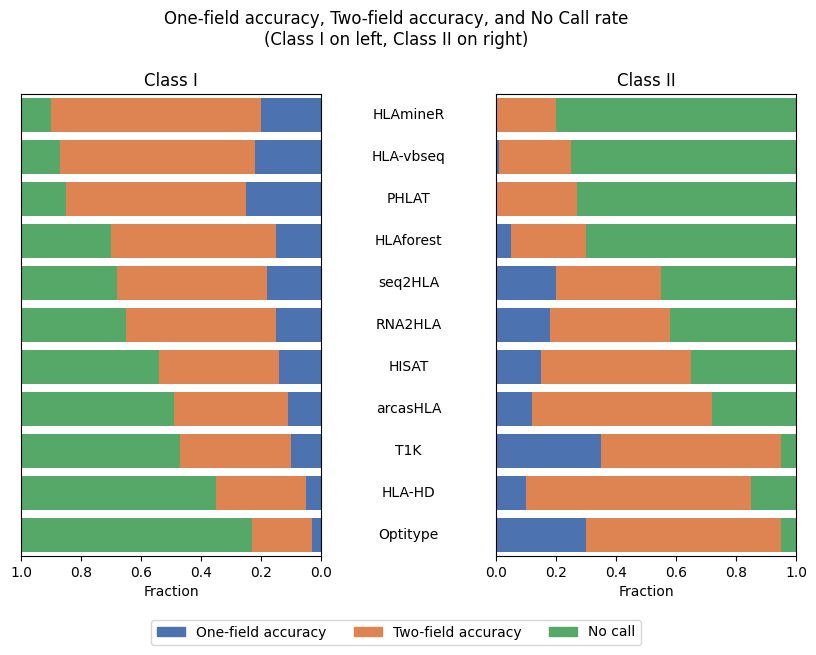

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1) Data Assumptions
# --------------------------------------------------------------------
# We assume you have a DataFrame named df that already includes
# these columns (after pivoting or merging):
#   "Tool"           (str)  : tool name
#   "I_oneField"     (float): fraction of calls for Class I that were correct at one-field
#   "I_twoField"     (float): fraction of calls for Class I that were correct at two-field
#   "I_noCall"       (float): fraction of calls for Class I that were no-calls
#   "II_oneField"    (float): fraction of calls for Class II that were correct at one-field
#   "II_twoField"    (float): fraction of calls for Class II that were correct at two-field
#   "II_noCall"      (float): fraction of calls for Class II that were no-calls
#
# These three fractions (oneField, twoField, noCall) presumably sum to 1
# per class, though that is not strictly required.

# For demonstration, let's build a small example DataFrame:
df = pd.DataFrame({
    "Tool":       ["Optitype","T1K","HLA-HD","HISAT","arcasHLA","RNA2HLA","seq2HLA","HLAforest","PHLAT","HLA-vbseq","HLAmineR"],
    "I_oneField": [0.20, 0.25, 0.22, 0.18, 0.15, 0.15, 0.14, 0.11, 0.10, 0.05, 0.03],
    "I_twoField": [0.70, 0.60, 0.65, 0.50, 0.55, 0.50, 0.40, 0.38, 0.37, 0.30, 0.20],
    "I_noCall":   [0.10, 0.15, 0.13, 0.32, 0.30, 0.35, 0.46, 0.51, 0.53, 0.65, 0.77],
    "II_oneField":[0.30, 0.35, 0.10, 0.15, 0.12, 0.18, 0.20, 0.05, 0.00, 0.01, 0.00],
    "II_twoField":[0.65, 0.60, 0.75, 0.50, 0.60, 0.40, 0.35, 0.25, 0.27, 0.24, 0.20],
    "II_noCall":  [0.05, 0.05, 0.15, 0.35, 0.28, 0.42, 0.45, 0.70, 0.73, 0.75, 0.80]
})

# Optionally, sort by Class I, two-field descending, so top tool is best
df = df.sort_values(by="I_twoField", ascending=False).reset_index(drop=True)

# --------------------------------------------------------------------
# 2) Create the Diverging Bar Plot with Stacked Bars
# --------------------------------------------------------------------
fig = plt.figure(figsize=(10, 6))
# We'll create 3 subplots: left=Class I, center=labels, right=Class II.
# The center is narrow, to hold just the tool labels.
gs = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[1, 0.5, 1], wspace=0.05)

ax_left = fig.add_subplot(gs[0, 0])
ax_center = fig.add_subplot(gs[0, 1])
ax_right = fig.add_subplot(gs[0, 2])

# We'll define a horizontal position (y) for each row in df
y_positions = np.arange(len(df))

# We also define some colors for the stacked segments:
color_oneF   = "#4C72B0"  # e.g. a blue
color_twoF   = "#DD8452"  # e.g. a red/orange
color_noCall = "#55A868"  # e.g. a green

# --------------------------------------------------------------------
# 2A) Left subplot: Class I, stacked bars from right to left
# --------------------------------------------------------------------
# For each row i in df, we build the stacked bar of [oneField, twoField, noCall].
# Because we want 1.0 near the center axis, we invert x-axis after plotting.

for i, row in df.iterrows():
    y = i
    # Start at 0 for the leftmost portion (which is actually the "center" side,
    # because we will invert the axis).
    # We'll stack them so that the sum is 1.0 across the bar's "length".
    left_oneField = 0
    width_oneField = row["I_oneField"]
    
    left_twoField = left_oneField + width_oneField
    width_twoField = row["I_twoField"]
    
    left_noCall = left_twoField + width_twoField
    width_noCall = row["I_noCall"]
    
    # Plot oneField
    ax_left.barh(y, width_oneField, left=left_oneField, color=color_oneF, align="center")
    # Plot twoField stacked after oneField
    ax_left.barh(y, width_twoField, left=left_twoField, color=color_twoF, align="center")
    # Plot noCall stacked after twoField
    ax_left.barh(y, width_noCall, left=left_noCall, color=color_noCall, align="center")

ax_left.set_ylim(-0.5, len(df)-0.5)
ax_left.set_xlim(0, 1)
ax_left.invert_xaxis()  # so 1.0 is near the center
ax_left.invert_yaxis()  # so the top row is at y=0
ax_left.set_xlabel("Fraction")
ax_left.set_title("Class I")

# Hide y-ticks; we'll place the tool labels in the center axis
ax_left.set_yticks([])

# --------------------------------------------------------------------
# 2B) Center subplot: tool labels
# --------------------------------------------------------------------
ax_center.set_xlim(0, 1)
ax_center.set_ylim(ax_left.get_ylim())
ax_center.invert_yaxis()

# Remove all spines/ticks
for spine in ax_center.spines.values():
    spine.set_visible(False)
ax_center.set_xticks([])
ax_center.set_yticks([])

# Place the tool labels in the center axis
for i, row in df.iterrows():
    tool_name = row["Tool"]
    ax_center.text(
        0.5, i, tool_name,
        ha="center", va="center", fontsize=10
    )

# --------------------------------------------------------------------
# 2C) Right subplot: Class II, stacked bars from left to right
# --------------------------------------------------------------------
for i, row in df.iterrows():
    y = i
    left_oneField = 0
    width_oneField = row["II_oneField"]
    
    left_twoField = left_oneField + width_oneField
    width_twoField = row["II_twoField"]
    
    left_noCall = left_twoField + width_twoField
    width_noCall = row["II_noCall"]
    
    # Plot oneField
    ax_right.barh(y, width_oneField, left=left_oneField, color=color_oneF, align="center")
    # Plot twoField stacked after oneField
    ax_right.barh(y, width_twoField, left=left_twoField, color=color_twoF, align="center")
    # Plot noCall stacked after twoField
    ax_right.barh(y, width_noCall, left=left_noCall, color=color_noCall, align="center")

ax_right.set_ylim(ax_left.get_ylim())
ax_right.invert_yaxis()  # keep the same top-to-bottom order
ax_right.set_xlim(0, 1)
ax_right.set_xlabel("Fraction")
ax_right.set_title("Class II")

ax_right.set_yticks([])
ax_right.set_yticklabels([])

# --------------------------------------------------------------------
# 3) Legend
# --------------------------------------------------------------------
# We'll create a custom legend with handles
handles = [
    plt.Rectangle((0,0),1,1, color=color_oneF, label="One-field accuracy"),
    plt.Rectangle((0,0),1,1, color=color_twoF, label="Two-field accuracy"),
    plt.Rectangle((0,0),1,1, color=color_noCall, label="No call")
]
fig.legend(handles=handles, loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.05))

plt.suptitle("One-field accuracy, Two-field accuracy, and No Call rate\n(Class I on left, Class II on right)", y=1.02)

plt.tight_layout()
plt.show()


##  Figure 5: accuracy by locus heatmap

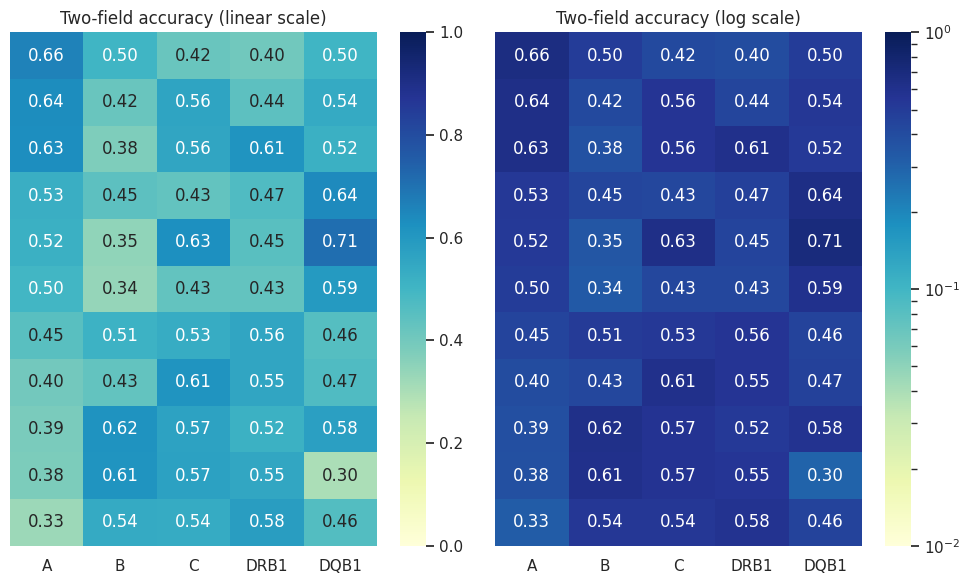

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# -----------------------------------------------------
# 1) Example: Compute Per-Locus Two-Field Accuracy
#    (Using our previously discussed accuracy approach)
# -----------------------------------------------------

# Assume we have an accuracy function, e.g. 'calculate_accuracy_per_locus',
# that returns the two-field accuracy for each tool at each locus for each dataset.
# For example, it might produce a list of dicts with keys: [Tool, Locus, Accuracy].
# You can adapt this snippet to your actual code that calculates per-locus accuracy.

def calculate_accuracy_per_locus(gs_file, pre_file, resolution=2):
    """
    Example function that returns a list of {Tool, Locus, Accuracy} for each locus.
    In practice, you'd adapt the 'calculate_accuracy' logic to track accuracy per locus
    rather than a single global metric. For demonstration, we return dummy data.
    """
    # In reality, you'd parse the gold-standard file, parse the tool predictions,
    # compute accuracy for each locus. Here, we'll just return an example:
    tool_name = pre_file.split("_d")[0]  # e.g. "arcas" if file is "arcas_d1.csv"
    # Suppose we have 5 classical loci: A, B, C, DRB1, DQB1
    loci = ["A", "B", "C", "DRB1", "DQB1"]
    # Just generate random accuracy for demonstration
    import random
    random.seed(hash((gs_file, pre_file)) % 999999)
    results = []
    for locus in loci:
        acc = round(random.uniform(0.0, 1.0), 2)  # random for demonstration
        results.append({
            "Tool": tool_name,
            "Locus": locus,
            "Accuracy": acc
        })
    return results

# Let's say we have multiple tools and multiple datasets:
tools = ["OptiType", "T1K", "HLA-HD", "arcasHLA", "HISAT", "RNA2HLA", 
         "seq2HLA", "PHLAT", "HLAforest", "HLA-vbseq", "HLAmineR"]
datasets = [1, 2, 3, 4, 5, 6, 7, 8]

# We'll store per-locus accuracy in a list
all_rows = []
for tool in tools:
    for ds in datasets:
        gs_file = f"../datasets/{ds}_gs.csv"
        pre_file = f"{tool}_d{ds}.csv"
        # We'll pretend this function returns a list of {Tool, Locus, Accuracy}
        per_locus = calculate_accuracy_per_locus(gs_file, pre_file, resolution=2)
        all_rows.extend(per_locus)

# Now 'all_rows' is a big list of dictionaries
df_per_locus = pd.DataFrame(all_rows)
# df_per_locus should have columns: ["Tool", "Locus", "Accuracy"]

# Next, we want to *aggregate* across all datasets to get a single final
# two-field accuracy per tool-locus. We'll just take the mean across datasets:
df_agg = df_per_locus.groupby(["Tool", "Locus"], as_index=False).agg({"Accuracy": "mean"})

# -----------------------------------------------------
# 2) Pivot so each row is a tool, each column is a locus
# -----------------------------------------------------
df_pivot = df_agg.pivot(index="Tool", columns="Locus", values="Accuracy")

# Suppose we want the columns in the order A, B, C, DRB1, DQB1
df_pivot = df_pivot[["A", "B", "C", "DRB1", "DQB1"]]

# For demonstration, let's fill any missing with 0
df_pivot = df_pivot.fillna(0.0)

# Optionally, sort by one of the columns, e.g. sort by "A" descending
df_pivot = df_pivot.sort_values(by="A", ascending=False)

# -----------------------------------------------------
# 3) Create Two Heatmaps (Side-by-Side)
#    A) Linear scale
#    B) Log scale
# -----------------------------------------------------
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)

# A) Linear scale heatmap
sns.heatmap(
    df_pivot,            # Data
    ax=ax1,
    cmap="YlGnBu",       # colormap
    vmin=0, vmax=1,      # range for [0,1]
    annot=True, fmt=".2f",
    cbar=True
)
ax1.set_title("Two-field accuracy (linear scale)")
ax1.set_xlabel("")  # optional
ax1.set_ylabel("")  # row labels are the tool names
# Keep tool labels horizontal if you prefer:
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# B) Log scale heatmap
import matplotlib.colors as mcolors
norm = mcolors.LogNorm(vmin=1e-2, vmax=1.0)  # adjust min if your lowest > 1e-2
sns.heatmap(
    df_pivot,
    ax=ax2,
    cmap="YlGnBu",
    norm=norm,          # log color scale
    annot=True, fmt=".2f",
    cbar=True
)
ax2.set_title("Two-field accuracy (log scale)")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()


## Figure 6: Miscalled Alleles  at each locus for each tool

/tmp/ipykernel_2729274/1987280151.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_2729274/1987280151.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_2729274/1987280151.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_2729274/1987280151.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


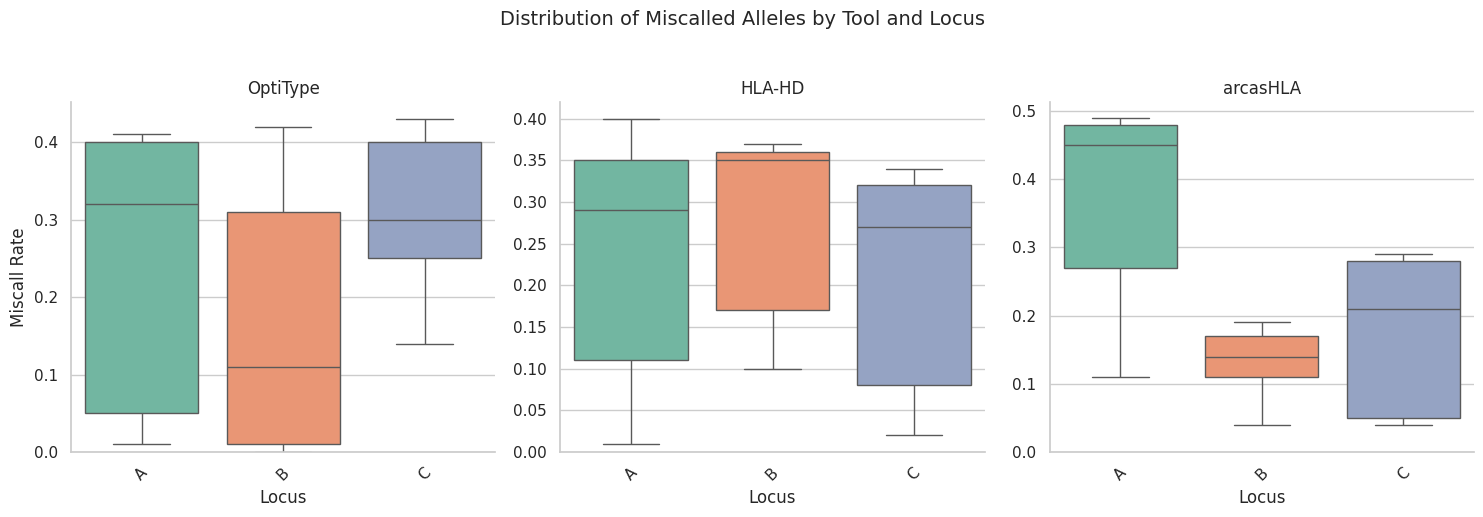

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Example: df_miscalled has columns ["Tool", "Locus", "Value", "Sample"]
# where "Value" is e.g. the fraction of miscalled alleles at that locus.
# Suppose we've already computed it, or read it from a CSV.
# df_miscalled = pd.read_csv("miscalled_alleles.csv")

# For demonstration, let's build a dummy DataFrame:
data = {
    "Tool":   ["OptiType","OptiType","OptiType","HLA-HD","HLA-HD","HLA-HD",
               "arcasHLA","arcasHLA","arcasHLA"] * 5,  # repeated for multiple samples
    "Locus":  ["A","B","C","A","B","C","A","B","C"] * 5,
    "Sample": [f"S{i}" for i in range(1,46)],  # 45 total sample-locus-tool combos
    "Value":  []  # we'll fill random for demonstration
}

import random
random.seed(42)

vals = []
for i in range(45):
    # e.g., a random fraction of miscalls between 0 and 0.5
    vals.append(round(random.uniform(0, 0.5), 2))
data["Value"] = vals

df_miscalled = pd.DataFrame(data)

# -------------------------------------------------------------------
# Create the catplot: each subplot is one Tool, x-axis is Locus,
# a box plot of "Value" for each Locus, across multiple samples
# for that tool.
# -------------------------------------------------------------------
g = sns.catplot(
    x="Locus",
    y="Value",
    col="Tool",
    col_wrap=3,         # how many subplots per row (adjust as needed)
    data=df_miscalled,
    kind="box",
    sharex=False,
    sharey=False,       # each tool can have its own y-scale (or set to True)
    palette="Set2"      # choose a color palette
)

g.set_titles("{col_name}")                 # Title of each subplot is the Tool name
g.set_axis_labels("Locus", "Miscall Rate") # Axis labels
g.set(ylim=(0, None))                      # y-axis starts at 0, up to max data
for ax in g.axes.flatten():
    # rotate the x-axis labels if needed
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.suptitle("Distribution of Miscalled Alleles by Tool and Locus", y=1.03, fontsize=14)
plt.tight_layout()
plt.show()


## Figure 7: Misclassification rate of alleles 

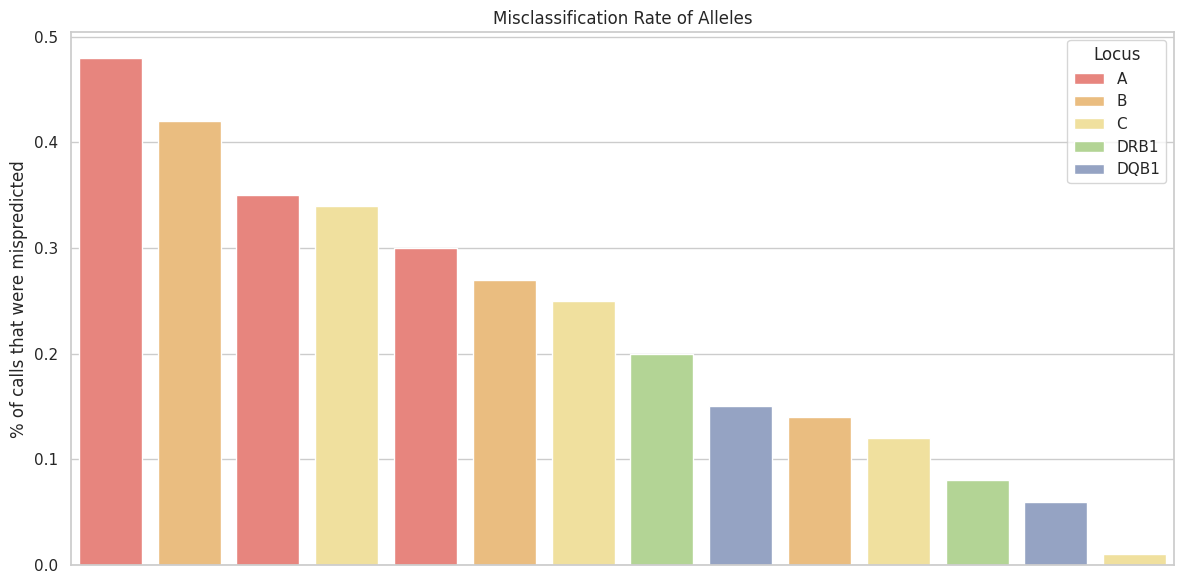

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# Example: df_misclassified is a DataFrame with (at least) the columns:
#   "Locus" : one of ["A", "B", "C", "DRB1", "DQB1"]
#   "MisclassificationRate" : float (e.g. 0.0 to 0.5) for that call
# Additional columns might include "Tool" or "Sample" if you want more info.
# 
# Each row represents one call or sample-locus combination. For a large dataset,
# you might have many rows. We'll just create a small example for demonstration.
# --------------------------------------------------------------------
data = {
    "Locus": ["A","B","A","C","A","B","C","DRB1","DQB1","B","C","DRB1","DQB1","C"],
    "MisclassificationRate": [0.48, 0.42, 0.35, 0.34, 0.3, 0.27, 0.25, 0.20, 0.15, 
                              0.14, 0.12, 0.08, 0.06, 0.01]
}
df_misclassified = pd.DataFrame(data)

# If your real data has many calls, you'll have far more rows.

# --------------------------------------------------------------------
# Sort by misclassification rate in descending order
# --------------------------------------------------------------------
df_sorted = df_misclassified.sort_values("MisclassificationRate", ascending=False).reset_index(drop=True)

# --------------------------------------------------------------------
# Create a bar plot of each call, color-coded by locus
# --------------------------------------------------------------------
plt.figure(figsize=(12,6))

# If you'd like specific colors for each locus, define them in a dictionary:
custom_palette = {
    "A":     "#F8766D",  # e.g. red
    "B":     "#FCBF6E",  # e.g. orange
    "C":     "#FEE890",  # e.g. yellow
    "DRB1":  "#B2DF8A",  # e.g. green
    "DQB1":  "#8DA0CB"   # e.g. blue/purple
}

sns.barplot(
    x=df_sorted.index,               # x is the "rank" (call index)
    y="MisclassificationRate",       # y is the fraction misclassified
    hue="Locus",                     # color-coded by locus
    data=df_sorted,
    palette=custom_palette
)

plt.title("Misclassification Rate of Alleles")
plt.xlabel("")  # we don't need an x-axis label
plt.ylabel("% of calls that were mispredicted")

# Hide the x-ticks, as each bar is an individual call
plt.xticks([], [])

# Optionally, set y-limit if you want a specific range
# plt.ylim(0, 0.5)  # if your max is 0.5

plt.legend(title="Locus", loc="best")
plt.tight_layout()
plt.show()


## Figure 8: Accuracy Against Read Length